# ***PROYECTO 1 - Relación Minutos Ingreso***

Integrantes: Claudia Herenia Galindo Rojas, Jaime Andrés Carvajal Gutierrez, Sergio Herrera Quijano, Edison Yesid Herrera, Johana Trejos, Luisa Fernanda Cristancho

Se cuenta con la base de datos de una empresa operadora de telecomunicaciones donde se relacionan seis variables por usuario: número de identificación del usuario, la tenencia de tarjeta de crédito o no, el tiempo de antigüedad del equipo actual del usuario, el tiempo en minutos de servicio que ha utilizado la línea y el ingreso total del usuario. Se quiere determinar si existe alguna relación entre el ingreso del usuario y los minutos que ha utilizado la línea (equipo).

In [271]:
#En esta celda se importan las librerias que tendran uso en este ejercicio, ademas se iporta el "dataframe" con el que se llevara a cabo el analisis.
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 
import random
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

df = pd.read_csv("https://raw.githubusercontent.com/Izainea/seminario-de-programacion/master/Cuadernos/Clase%202/Bases/Credito_dias.csv")
# Se utilizan las funciones .info y . describe para ver el estado y calidad de los datos consignados en el "DataFrame"
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   totmou       10000 non-null  float64
 1   totrev       10000 non-null  float64
 2   creditcd     9848 non-null   object 
 3   eqpdays      10000 non-null  int64  
 4   Customer_ID  10000 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 390.8+ KB


,totmou,totrev,eqpdays,Customer_ID
count,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,7692.804866,1042.133807,386.794500,1.049965e+06
std,8657.917883,857.144895,252.720196,2.879424e+04
min,0.000000,11.100000,-5.000000,1.000014e+06
25%,2576.000000,526.787500,210.000000,1.025053e+06
50%,5262.000000,820.235000,338.000000,1.049652e+06
75%,9823.250000,1272.975000,522.000000,1.074798e+06
max,163264.176700,13426.600000,1823.000000,1.099992e+06


# Filtrado
Luego de observar la tipología de datos en las columnas (variables) y el número de datos "nulos" y "no nulos" que contienen, se procede a hacer el filtrado de datos, comenzando por evaluar la pertinencia de las variables que son útiles y cuáles no lo son. En ese orden de ideas, se decide prescindir de la columna "Customer_ID", ya que solo representa un identificador para cada usuario en lugar de una característica relevante. En el mismo sentido, se observa en la descripción anterior de la base de datos que la variable "creditcd" contiene celdas nulas o vacías, las cuales se decide rellenar con "NR" de No Registra. De igual manera, se reemplazan los valores negativos de la variable "eqpdays" con el valor de la media de los valores positivos, ya que si la unidad de la columna son "días", no es lógico que hayan valores negativos.

In [272]:
df= df.drop("Customer_ID", axis=1) # Se elimina la columna "Customer_ID"
df["creditcd"] = df["creditcd"].fillna("NR") # Se rellenan los nan de la columna "creditcd" con NR
media_no_negativos = df[df["eqpdays"] >= 0]["eqpdays"].mean() # Se calcula la media de los valores positivos
df.loc[df["eqpdays"] < 0, "eqpdays"] = media_no_negativos # Se remplazan los valores negativos por la media

print(df["creditcd"].value_counts())
df.info()
df.describe()


creditcd
Y     6796
N     3052
NR     152
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   totmou    10000 non-null  float64
 1   totrev    10000 non-null  float64
 2   creditcd  10000 non-null  object 
 3   eqpdays   10000 non-null  float64
dtypes: float64(3), object(1)
memory usage: 312.6+ KB


C:\Users\USER\AppData\Local\Temp\ipykernel_1248\3515407442.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '387.4966940492887' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["eqpdays"] < 0, "eqpdays"] = media_no_negativos # Se remplazan los valores negativos por la media


,totmou,totrev,eqpdays
count,10000.000000,10000.000000,10000.000000
mean,7692.804866,1042.133807,387.496694
std,8657.917883,857.144895,252.178564
min,0.000000,11.100000,0.000000
25%,2576.000000,526.787500,211.000000
50%,5262.000000,820.235000,338.500000
75%,9823.250000,1272.975000,522.000000
max,163264.176700,13426.600000,1823.000000


# Graficas
Una vez filtrados y ajustados los valores del DataFrame, se verifica que efectivamente no haya valores nulos o negativos, y se observan las propiedades estadísticas de las variables numéricas y categóricas. A partir de este punto, ya se pueden realizar las gráficas correspondientes para el análisis estadístico del conjunto de datos.

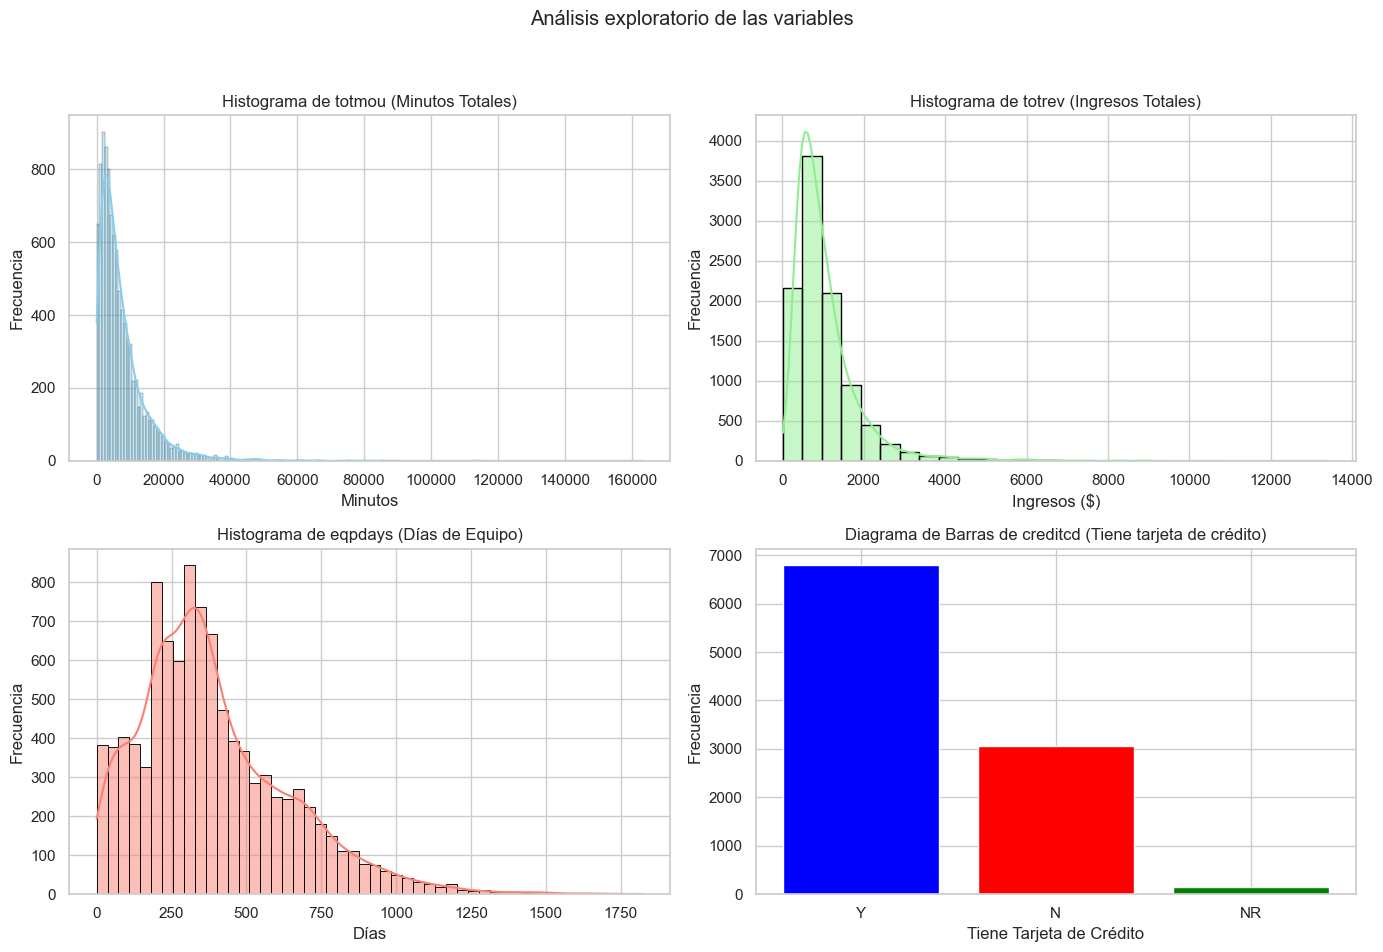

In [273]:
df_num = df[["eqpdays", "totmou", "totrev"]]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis exploratorio de las variables')

# Histogramas para variables numéricas
sns.histplot(df['totmou'], bins=200, kde=True, color='skyblue', edgecolor='black', ax=axes[0, 0])
axes[0, 0].set_title('Histograma de totmou (Minutos Totales)')
axes[0, 0].set_xlabel('Minutos')
axes[0, 0].set_ylabel('Frecuencia')

sns.histplot(df['totrev'], bins=28,kde=True, color='lightgreen', edgecolor='black', ax=axes[0, 1])
axes[0, 1].set_title('Histograma de totrev (Ingresos Totales)')
axes[0, 1].set_xlabel('Ingresos ($)')
axes[0, 1].set_ylabel('Frecuencia')

sns.histplot(df['eqpdays'], bins=50, kde=True, color='salmon', edgecolor='black', ax=axes[1, 0])
axes[1, 0].set_title('Histograma de eqpdays (Días de Equipo)')
axes[1, 0].set_xlabel('Días')
axes[1, 0].set_ylabel('Frecuencia')

# Diagrama de barras para la variable categórica
credit_counts = df['creditcd'].value_counts()
axes[1, 1].bar(credit_counts.index, credit_counts.values, color=['blue', 'red', "green"])
axes[1, 1].set_title('Diagrama de Barras de creditcd (Tiene tarjeta de crédito)')
axes[1, 1].set_xlabel('Tiene Tarjeta de Crédito')
axes[1, 1].set_ylabel('Frecuencia')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### ***Conclusiones de histogramas y grafico de barras.***

En cuanto a la distribución de las variables numéricas del conjunto de datos, podemos observar que tanto la variable de "minutos totales" como la variable de "Ingresos Totales" tienden a seguir una distribución exponencial o una distribución con un índice de asimetría bastante pronunciada hacia la derecha. Esto indica que la mayoría de los individuos de la población han gastado menos de 9823.5 minutos (totmou) con ingresos inferiores a 1273 dólares (totrev), valores correspondientes al tercer cuartil de cada variable. Por otro lado, en lo que respecta a los días de antigüedad de los usuarios con el equipo actual (eqpdays), los datos muestran una distribución más normal, con una asimetría hacia la derecha menos pronunciada que las otras variables. Esto sugiere que al menos la mitad de los usuarios tienen 338.5 días de antigüedad con el equipo actual, siendo este valor el segundo cuartil.

En cuanto a la variable categórica, el diagrama de barras muestra que los usuarios sin tarjeta de crédito representan aproximadamente la mitad de aquellos que sí la tienen. Sin embargo, esta variable no muestra un agrupamiento claro de sus categorías en el gráfico de dispersión.

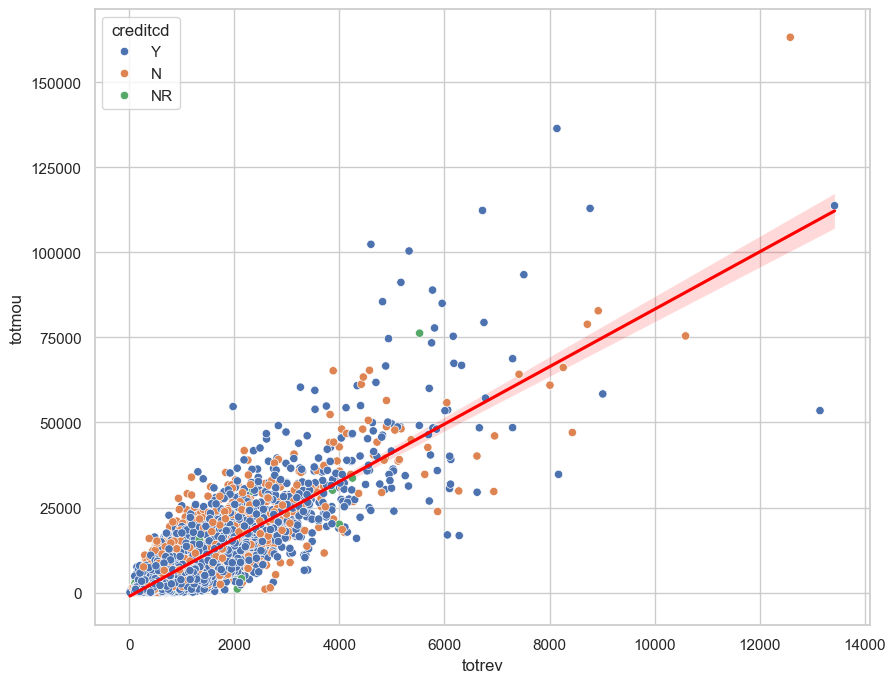

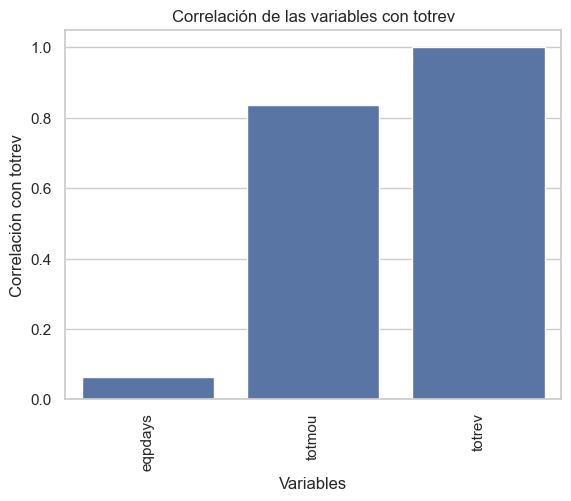

eqpdays    0.063931
totmou     0.835485
totrev     1.000000
Name: totrev, dtype: float64


In [274]:
# Grafica de dispersion con el ajuste a recta
plt.figure(figsize=(10, 8))
sns.regplot(x=df["totrev"], y=df["totmou"], scatter=False, line_kws={"color": "red"})
sns.scatterplot(x=df["totrev"], y = df["totmou"], data= df, hue="creditcd")
plt.show()
# Grafica de barras mostrando el valor de correlación de las variables numericas.
correlation = df_num.corr()["totrev"]
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlación de las variables con totrev')
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Correlación con totrev')
plt.show()

print(correlation)

#### **¿Existe relación alguna entre el total de minutos usados con la compañía y el ingreso total de los clientes?**

En efecto, la relación aproximada de la nube de datos es directa, ya que la tendencia general es que a medida que aumenta el ingreso del usuario, también aumenta el tiempo en minutos de uso del equipo. Esto corresponde a la relación intuitiva que pueden tener estas dos variables. A mayor disponibilidad de dinero por parte del usuario, mayor provecho puede obtener de su equipo sin sentir algún tipo de limitación monetaria.

#### ***CONCLUSIÓN SCATTERPLOT***

Como se mencionó en la respuesta a la pregunta anterior, la relación directa entre el ingreso por usuario y el tiempo en minutos de uso del equipo es evidente, con un valor de correlación de 0.83 entre ambas variables. Además, visualmente se puede observar una linealidad en la dispersión de los datos, confirmando así la relación entre las variables. Por otro lado, al identificar cada punto bajo la categoría de tenencia de tarjeta de crédito, se evidencia que en los tres casos (Y, N, NR) no existe un agrupamiento de los datos por estas categorías, sugiriendo que esta variable no tiene un impacto en la relación lineal entre las variables evaluadas.

#### **MODELAMIENTO ML**


In [275]:
varnum = ["totrev" , "eqpdays"]

y = df["totmou"]
X = df[varnum]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, shuffle=True)

modelorl=LinearRegression()
modelosgd=SGDRegressor()
modeloRid=Ridge()
modeloLss=Lasso()
ModRand = RandomForestRegressor()

modelorl.fit(X_train, y_train)
print("Modelo Regresion Lineal: %3f" % modelorl.score(X_test, y_test))
modelosgd.fit(X_train, y_train)
print("Modelo SGD: %3f" % modelosgd.score(X_test, y_test))
modeloRid.fit(X_train, y_train)
print("Modelo Ridge: %3f" % modeloRid.score(X_test, y_test))
modeloLss.fit(X_train, y_train)
print("Modelo Lasso: %3f" % modeloLss.score(X_test, y_test))
ModRand.fit(X_train, y_train)

predic = modelorl.score(X, y)
print("Coeficiente de determinación en el entrenamiento: ", predic)
print("MAE: ", mean_absolute_error (y_test, modelorl.predict(X_test)))
print("MSE: ", mean_squared_error (y_test, modelorl.predict(X_test)))
print("RMSE: ", np.sqrt (mean_squared_error(y_test, modelorl.predict(X_test))))
#print("Modelo Regressor: %3f" % ModRand.score(X_test, y_test))


print(modelorl.predict(X.sample(10)))



Modelo Regresion Lineal: 0.735014
Modelo SGD: -1606190692935827193856.000000
Modelo Ridge: 0.735014
Modelo Lasso: 0.735014
Coeficiente de determinación en el entrenamiento:  0.7239301408388368
MAE:  2891.481100098397
MSE:  20721950.769400865
RMSE:  4552.136945369819
[10800.23361928  7149.89424435  2521.91808703  2204.41480042
 16989.89162447  9055.93741969  2420.87862804  5634.60303927
  8104.48814661  8433.27708469]
